In [4]:
%matplotlib inline

import numpy as np
from pprint import pprint

from PIL import Image
import matplotlib.pyplot as plt

from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as cp
from torch.autograd import grad
import torchvision
from typing import Any, Callable, List, Optional, Type, Union

from torch import Tensor
from torchvision import models, datasets, transforms
from collections import OrderedDict
torch.manual_seed(50)

print(torch.__version__, torchvision.__version__)



1.12.1+cu113 0.13.1+cu113


In [18]:
dataset = datasets.CIFAR100("~/.torch", download=True)
transform_operation = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


def reverse_transform(image):
    """ reverse the normalized image back to JPG format """
    output = ((image.detach().cpu().numpy().transpose(1, 2, 0)*np.array([[[0.229, 0.224, 0.225]]]) + np.array([[[0.485, 0.456, 0.406]]]))*255)
    output[output > 255] = 255
    output[output < 0] = 0
    output = output.astype(np.uint8)
    return output

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"


loss = torch.nn.CrossEntropyLoss()

Files already downloaded and verified


In [15]:
class _DenseLayer(nn.Module):
    def __init__(
        self, num_input_features: int, growth_rate: int, bn_size: int, drop_rate: float, memory_efficient: bool = False
    ) -> None:
        super().__init__()
        self.norm1 = nn.BatchNorm2d(num_input_features)
        self.relu1 = nn.Sigmoid()
        self.conv1 = nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False)

        self.norm2 = nn.BatchNorm2d(bn_size * growth_rate)
        self.relu2 = nn.Sigmoid()
        self.conv2 = nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False)

        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs: List[Tensor]) -> Tensor:
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input: List[Tensor]) -> bool:
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input: List[Tensor]) -> Tensor:
        def closure(*inputs):
            return self.bn_function(inputs)

        return cp.checkpoint(closure, *input)

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: List[Tensor]) -> Tensor:  # noqa: F811
        pass

    @torch.jit._overload_method  # noqa: F811
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input: Tensor) -> Tensor:  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
        return new_features


class _DenseBlock(nn.ModuleDict):
    _version = 2

    def __init__(
        self,
        num_layers: int,
        num_input_features: int,
        bn_size: int,
        growth_rate: int,
        drop_rate: float,
        memory_efficient: bool = False,
    ) -> None:
        super().__init__()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.add_module("denselayer%d" % (i + 1), layer)

    def forward(self, init_features: Tensor) -> Tensor:
        features = [init_features]
        for name, layer in self.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features: int, num_output_features: int) -> None:
        super().__init__()
        self.norm = nn.BatchNorm2d(num_input_features)
        self.relu = nn.Sigmoid()
        self.conv = nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)


class DenseNet(nn.Module):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_.
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_.
    """

    def __init__(
        self,
        growth_rate: int = 32,
        block_config = (6, 12, 24, 16),
        num_init_features: int = 64,
        bn_size: int = 4,
        drop_rate: float = 0,
        num_classes: int = 1000,
        memory_efficient: bool = False,
    ) -> None:

        super().__init__()

        # First convolution
        self.features = nn.Sequential(
            OrderedDict(
                [
                    ("conv0", nn.Conv2d(3, num_init_features, kernel_size=7, stride=2, padding=3, bias=False)),
                    ("norm0", nn.BatchNorm2d(num_init_features)),
                    ("relu0", nn.ReLU(inplace=True)),
                    ("pool0", nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
                ]
            )
        )

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.features.add_module("denseblock%d" % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2)
                self.features.add_module("transition%d" % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module("norm5", nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)

    def forward(self, x: Tensor) -> Tensor:
        features = self.features(x)
        out = F.sigmoid(features)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = torch.flatten(out, 1)
        out = self.classifier(out)
        return out


def _densenet(
    growth_rate: int,
    block_config,
    num_init_features: int,
    weights,
    progress: bool,
    **kwargs: Any,
) -> DenseNet:


    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)

    return model




def densenet121(*, weights = None, progress: bool = True, **kwargs: Any) -> DenseNet:
    r"""Densenet-121 model from
    `Densely Connected Convolutional Networks <https://arxiv.org/abs/1608.06993>`_.
    Args:
        weights (:class:`~torchvision.models.DenseNet121_Weights`, optional): The
            pretrained weights to use. See
            :class:`~torchvision.models.DenseNet121_Weights` below for
            more details, and possible values. By default, no pre-trained
            weights are used.
        progress (bool, optional): If True, displays a progress bar of the download to stderr. Default is True.
        **kwargs: parameters passed to the ``torchvision.models.densenet.DenseNet``
            base class. Please refer to the `source code
            <https://github.com/pytorch/vision/blob/main/torchvision/models/densenet.py>`_
            for more details about this class.
    .. autoclass:: torchvision.models.DenseNet121_Weights
        :members:
    """

    return _densenet(32, (6, 12, 24, 16), 64, weights, progress, **kwargs)
 
densenet = densenet121(num_classes=100).to(device)


## Honest participants
This is the image used by the honest trainer, where only the gradients will be shared to other trainers (under the name original_derivatives)

In [16]:
example_index = 25
ground_truth_data = transform_operation(dataset[example_index][0]).to(device).unsqueeze(0)
ground_truth_label = torch.Tensor([dataset[example_index][1]]).to(device).long()
ground_truth_label = torch.nn.functional.one_hot(ground_truth_label, num_classes=100)

model_prediction = densenet(ground_truth_data)

predicted_loss = loss(model_prediction, ground_truth_label.float())

derivatives = torch.autograd.grad(predicted_loss, densenet.parameters())


original_derivatives = [layer_derivative.detach().clone() for layer_derivative in derivatives]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Plot the ground truth image

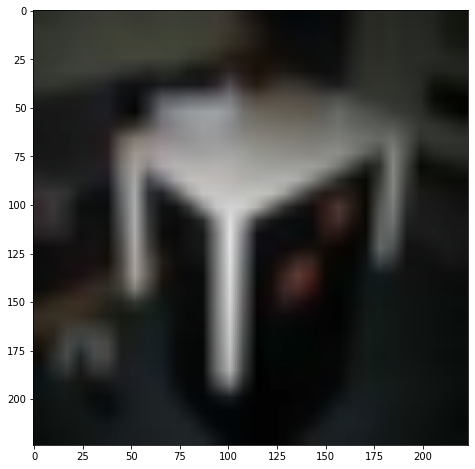

In [19]:
ground_truth_jpg = reverse_transform(ground_truth_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(ground_truth_jpg)

## Generate dummy data and dummy label
Here, we will generate an image using random pixel and random label

Dummy label is 30.


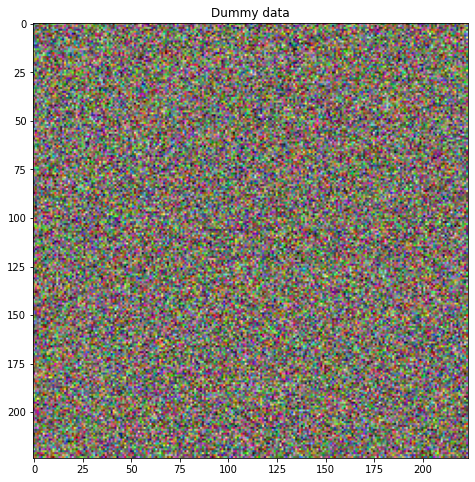

In [20]:
dummy_data = torch.randn(ground_truth_data.size()).to(device).requires_grad_(True)
dummy_label = torch.randn(ground_truth_label.size()).to(device).requires_grad_(True)

dummy_data_jpg = reverse_transform(dummy_data[0])
plt.figure(figsize=(8, 8))
plt.imshow(dummy_data_jpg)
plt.title("Dummy data")
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

In [21]:
optimizer = torch.optim.LBFGS([dummy_data, dummy_label])

history = []
for iters in range(300):
    def closure():
        optimizer.zero_grad()

        pred = densenet(dummy_data) 
        dummy_onehot_label = torch.nn.functional.softmax(dummy_label, dim=-1)
        dummy_loss = loss(pred, dummy_onehot_label) # TODO: fix the gt_label to dummy_label in both code and slides.
        dummy_dy_dx = torch.autograd.grad(dummy_loss, densenet.parameters(), create_graph=True)
        
        grad_diff = 0
        grad_count = 0
        for gx, gy in zip(dummy_dy_dx, original_derivatives): 
            grad_diff += ((gx - gy)**2).sum()
            grad_count += gx.nelement()
        #grad_diff = grad_diff / grad_count
        grad_diff.backward()
        
        return grad_diff
    
    optimizer.step(closure)
    if iters % 1 == 0: 
        current_loss = closure()
        print(iters, datetime.now().isoformat(), "%.6f" % current_loss.item())
    history.append(reverse_transform(dummy_data[0]))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 2022-09-01T03:40:56.314303 0.062699
1 2022-09-01T03:41:02.566057 0.031838
2 2022-09-01T03:41:08.447154 0.021263
3 2022-09-01T03:41:14.351226 0.014933
4 2022-09-01T03:41:20.283662 0.010097
5 2022-09-01T03:41:26.249095 0.007035
6 2022-09-01T03:41:32.193385 0.005034
7 2022-09-01T03:41:38.120973 0.003784
8 2022-09-01T03:41:44.779777 0.002982
9 2022-09-01T03:41:51.052577 0.002414
10 2022-09-01T03:41:57.024030 0.002009
11 2022-09-01T03:42:03.351152 0.001708
12 2022-09-01T03:42:09.273380 0.001466
13 2022-09-01T03:42:15.225107 0.001298
14 2022-09-01T03:42:21.170431 0.001159
15 2022-09-01T03:42:27.190522 0.001040
16 2022-09-01T03:42:33.171470 0.000952
17 2022-09-01T03:42:39.170523 0.000875
18 2022-09-01T03:42:45.108855 0.000806
19 2022-09-01T03:42:51.059239 0.000748
20 2022-09-01T03:42:56.979076 0.000702
21 2022-09-01T03:43:03.496752 0.000655
22 2022-09-01T03:43:09.436792 0.000621
23 2022-09-01T03:43:15.394277 0.000590
24 2022-09-01T03:43:21.330514 0.000556
25 2022-09-01T03:43:27.261937 0.000

# Plot the evolution of the image

Dummy label is 84.


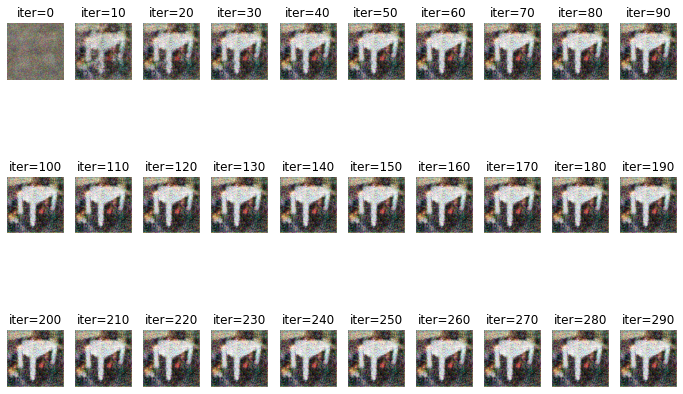

In [22]:
plt.figure(figsize=(12, 8))
for i in range(30):
  plt.subplot(3, 10, i + 1)
  plt.imshow(history[i*10])
  plt.title("iter=%d" % (i*10))
  plt.axis('off')
print("Dummy label is %d." % torch.argmax(dummy_label, dim=-1).item())

# Plot the final output

Text(0.5, 1.0, 'Dummy data')

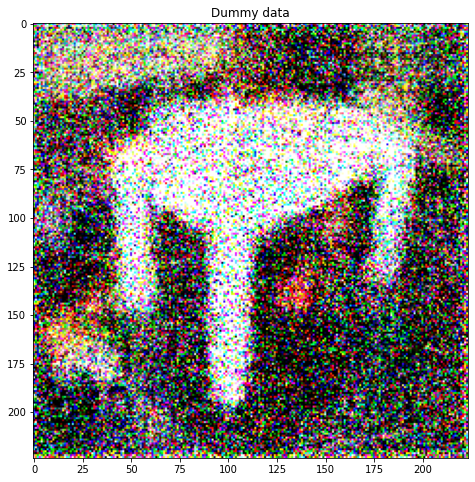

In [23]:
plt.figure(figsize=(8, 8))
plt.imshow(history[-1])
plt.title("Dummy data")

# Plot MSE vs steps

Text(0.5, 1.0, 'MSE vs step of DenseNet')

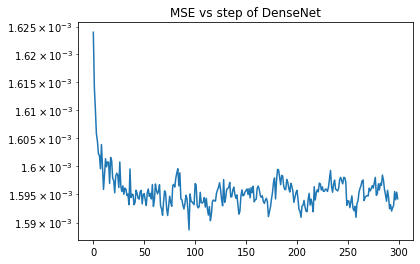

In [26]:
mse_array = [
    np.mean((ground_truth_jpg - history[i])**2)/255**2  for i in range(len(history))
]

plt.semilogy(np.arange(len(history)), mse_array)
plt.title("MSE vs step of DenseNet")

In [25]:
print(mse_array)

[0.0016239686233970713, 0.0016140263294860426, 0.0016101503918560889, 0.001605782223019927, 0.0016044837052468046, 0.0016021645586339112, 0.001601910371991934, 0.001599545455437077, 0.001603844867195244, 0.001599761125855571, 0.0015958853925557152, 0.0015986719442679033, 0.0016013283377076322, 0.0015998880148464616, 0.0016007709252001455, 0.0016006996139959252, 0.0015969497480364694, 0.001601562091339804, 0.0016010261334926128, 0.001597854419545596, 0.0015974484156407662, 0.0015952868075334709, 0.0015982632840717986, 0.0015987631776566834, 0.0015984174511307792, 0.0015962036366834315, 0.0016007521268311246, 0.001596490720471195, 0.0015955026822820633, 0.0015965124816266377, 0.0015950249585128169, 0.0015961281367122013, 0.0015959370880705222, 0.0015948001954049593, 0.0015950633725712506, 0.0015931760776205907, 0.0015995121496310942, 0.0015944476238207701, 0.0015950347663575234, 0.001594974999803843, 0.0015931760776205907, 0.001593619269603266, 0.0015957515563414907, 0.001595169317727090